#### 실습 과제
- SSD의 기본 구조 이해: SSD의 기본 원리와 구조를 이해하기
- 사전 학습된 모델 사용: 사전 학습된 SSD 모델을 사용하여 이미지에서 객체를 검출하기
- 실제 데이터셋 사용: COCO와 같은 실제 데이터셋을 사용하여 SSD 모델을 학습시키고 평가하기
- 결과 시각화: 검출된 객체를 이미지에 시각화하여 결과를 확인하기

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import VOCDetection
from torch.utils.data import DataLoader

In [2]:

# 데이터셋을 전처리합니다.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Pascal VOC 데이터셋 경로 설정
voc_root = "./VOCdata"
year = "2012"

# PASCAL VOC 데이터셋을 다운로드하고 로드합니다.
image_set = "train"
trainset = VOCDetection(root=voc_root, year=year, image_set=image_set, download=True, transform=transform)

image_set = "val"
testset = VOCDetection(root=voc_root, year=year, image_set=image_set, download=True, transform=transform)

VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow",
    "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

label_map = {label: idx for idx, label in enumerate(VOC_CLASSES)}

def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1]['annotation'] for item in batch]

    processed_targets = []
    for target in targets:
        boxes = []
        labels = []
        if isinstance(target['object'], dict):
            obj = target['object']
            boxes.append([float(obj['bndbox']['xmin']), float(obj['bndbox']['ymin']), float(obj['bndbox']['xmax']), float(obj['bndbox']['ymax'])])
            labels.append(label_map[obj['name']])
        else:
            for obj in target['object']:
                boxes.append([float(obj['bndbox']['xmin']), float(obj['bndbox']['ymin']), float(obj['bndbox']['xmax']), float(obj['bndbox']['ymax'])])
                labels.append(label_map[obj['name']])

        processed_targets.append({
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64)
        })

    return images, processed_targets

trainloader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2, collate_fn=collate_fn)
testloader = DataLoader(testset, batch_size=16, shuffle=False, num_workers=2, collate_fn=collate_fn)

Using downloaded and verified file: ./VOCdata/VOCtrainval_11-May-2012.tar
Extracting ./VOCdata/VOCtrainval_11-May-2012.tar to ./VOCdata
Using downloaded and verified file: ./VOCdata/VOCtrainval_11-May-2012.tar
Extracting ./VOCdata/VOCtrainval_11-May-2012.tar to ./VOCdata


In [3]:
print(trainset)

Dataset VOCDetection
    Number of datapoints: 5717
    Root location: ./VOCdata
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )


In [4]:
# torchvision.models 모듈을 사용하여 사전 정의된 CNN 모델을 불러옵니다.
import torchvision.models.detection

# PASCAL VOC 클래스 수
num_classes = 20  # VOC는 20개의 클래스

# 사전 학습된 SSD 모델 불러오기
model = torchvision.models.detection.ssd300_vgg16(weights=torchvision.models.detection.SSD300_VGG16_Weights.COCO_V1)

model.eval()

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

#### SSD 모델은 여러 개의 feature map에서 객체를 검출합니다. 각 feature map의 채널 수는 다음과 같은 레이어에서 결정됩니다:

- Conv4_3의 출력: 512
- Conv7의 출력: 1024
- 추가된 feature layers의 출력: 512, 256, 256, 256
이 정보는 모델 아키텍처에서 직접 확인할 수 있습니다.



```
(17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(18): ReLU(inplace=True)
(19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(20): ReLU(inplace=True)
(21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(22): ReLU(inplace=True)

```
- Conv4_3는 VGG16 모델의 네 번째 convolutional 블록의 세 번째 convolutional 레이어 = 512





```
(7): Sequential(
  (0): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  (1): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 6))
  (2): ReLU(inplace=True)
  (3): Conv2d(1024, 1024, kernel_size=(1, 1), stride=(1, 1))
  (4): ReLU(inplace=True)
)
```
- Conv7는 VGG16 모델의 fully connected 레이어를 convolutional 레이어로 변환한 것입니다. 이는 extra 모듈 내에 있습니다.




```
(1): Sequential(
  (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU(inplace=True)
)
(2): Sequential(
  (0): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU(inplace=True)
)
(3-4): 2 x Sequential(
  (0): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU(inplace=True)
)

```
- 이는 VGG16의 기본 feature extractor 이후에 추가된 feature layers입니다.
- 코드에서 이를 확인하려면, extra 모듈 내에서 다음과 같은 부분들을 찾으면 됩니다.


#### Anchor Box 개수 (num_anchors) 파악
- anchor box의 개수는 각 feature map에서 사용하는 anchor box의 수입니다. 이는 주로 aspect_ratios와 scales 파라미터에 의해 결정됩니다.

- 모델 아키텍처에서 이 정보를 추출할 수 있습니다:

- aspect_ratios: 각 feature map에 대해 정의된 비율
- scales: 각 feature map에 대해 정의된 크기
- 이 정보를 바탕으로, 각 feature map에서 사용하는 anchor box의 수는 다음과 같이 계산됩니다:

- 첫 번째 feature map (aspect_ratios: [2]): 2개의 비율 (2:1, 1:2)
- 두 번째 feature map (aspect_ratios: [2, 3]): 6개의 비율 (2:1, 1:2, 3:1, 1:3)
- 세 번째 feature map (aspect_ratios: [2, 3]): 6개의 비율 (2:1, 1:2, 3:1, 1:3)
- 네 번째 feature map (aspect_ratios: [2, 3]): 6개의 비율 (2:1, 1:2, 3:1, 1:3)
- 다섯 번째 feature map (aspect_ratios: [2]): 2개의 비율 (2:1, 1:2)
- 여섯 번째 feature map (aspect_ratios: [2]): 2개의 비율 (2:1, 1:2)
- 이를 바탕으로, 각 feature map에서 사용하는 anchor box의 개수를 계산하면 다음과 같습니다:

- num_anchors = [4, 6, 6, 6, 4, 4]




```
DefaultBoxGenerator(aspect_ratios=[[2], [2, 3], [2, 3], [2, 3], [2], [2]])
```



In [5]:
from torchvision.models.detection.ssd import SSDHead

# 모델의 head를 수정하여 PASCAL VOC에 맞춤
in_channels = [512, 1024, 512, 256, 256, 256]  # 원본 SSD300_VGG16 아키텍처의 feature map 크기
num_anchors = [4, 6, 6, 6, 4, 4]  # 각 feature map에서의 anchor box 개수

# 새로운 SSDHead 생성
model.head = SSDHead(in_channels, num_anchors, num_classes)

In [6]:
# GPU가 사용 가능한지 확인하고, 사용할 수 있다면 device를 설정합니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda:0


In [7]:
# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [8]:
# 모델 훈련 함수
def train_model(model, trainloader, optimizer, num_epochs=10):

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (images, targets) in enumerate(trainloader):
            # 이미지를 device로 이동
            images = list(image.to(device) for image in images)

            # 타겟을 device로 이동
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()

            # 순전파
            loss_dict = model(images, targets)

            # 손실 계산
            losses = sum(loss for loss in loss_dict.values())

            # 역전파 및 최적화
            losses.backward()
            optimizer.step()

            # 손실(Loss)값 출력
            running_loss += losses.item()
            if i % 2000 == 1999:  # 매 20 미니배치마다 출력
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 20:.3f}')
                running_loss = 0.0

    print('Finished Training')

In [9]:
# 모델 평가 함수
def evaluate_model(model, testloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, targets in testloader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for output, target in zip(outputs, targets):
                pred_labels = output['labels']
                true_labels = target['labels']

                # 예측된 레이블 수와 실제 레이블 수 중 작은 값을 선택
                min_length = min(len(pred_labels), len(true_labels))

                # 레이블 수가 일치하는 부분만 비교
                correct += (pred_labels[:min_length] == true_labels[:min_length]).sum().item()
                total += len(true_labels)

    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the test images: {accuracy:.2f}%')

    return accuracy

In [10]:
model = model.to(device)

In [11]:
# 모델 학습
train_model(model, trainloader, optimizer, num_epochs=1)

Finished Training


In [12]:
# 모델 평가
evaluate_model(model, testloader)

Accuracy of the network on the test images: 32.25%


32.24805219484386

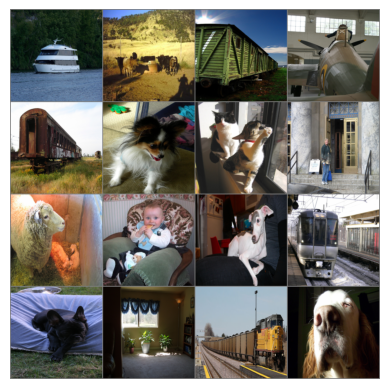

Image 1: boat
Image 2: cow
Image 3: train
Image 4: aeroplane
Image 5: train
Image 6: dog
Image 7: cat
Image 8: person
Image 9: sheep
Image 10: chair
Image 11: dog
Image 12: train
Image 13: dog
Image 14: pottedplant
Image 15: train
Image 16: dog


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def imshow(img):
    img = img.cpu().numpy()
    img = np.transpose(img, (1, 2, 0))

    # 이미지 값의 범위를 [0, 1]로 조정
    img = (img - img.min()) / (img.max() - img.min())

    plt.imshow(img)
    plt.axis('off')
    plt.show()

# 이미지 크기를 조정하는 함수
def resize_images(images, size=(224, 224)):
    resize = transforms.Resize(size)
    return [resize(img) for img in images]

# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 크기 조정
images_resized = resize_images(images)

# 이미지를 텐서로 변환
images_tensor = torch.stack(images_resized)

# 이미지 보여주기 (최대 16개)
num_images = min(16, images_tensor.size(0))
imshow(torchvision.utils.make_grid(images_tensor[:num_images], nrow=4))

# 정답(label) 출력
print('\n'.join(f'Image {i+1}: {VOC_CLASSES[labels[i]["labels"][0]]}' for i in range(num_images)))